Computing reference solution with dt = 1.000000e-05 ...
Computing ΔW curve with dt = 1.000000e-01 ...
Computing ΔW curve with dt = 1.000000e-02 ...
Computing ΔW curve with dt = 1.000000e-03 ...
Computing ΔW curve with dt = 1.000000e-04 ...


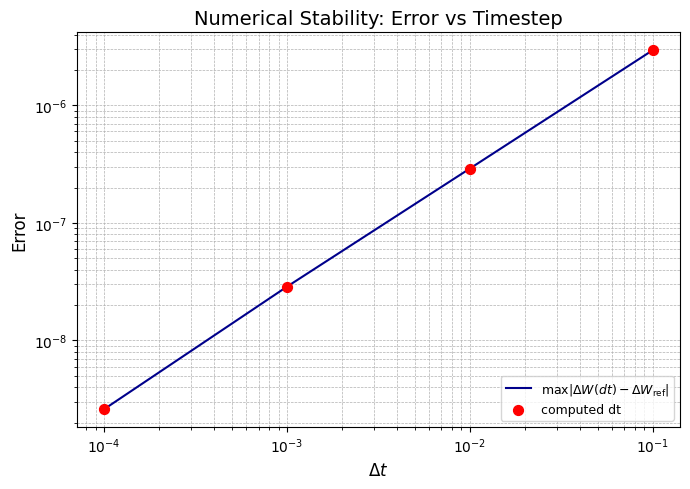


Δt          Error
1.0e-01    2.9416e-06
1.0e-02    2.8976e-07
1.0e-03    2.8677e-08
1.0e-04    2.6040e-09


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib as mpl
import time

# Plot style to match other notebooks
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['CMU Serif', 'Computer Modern Roman', 'DejaVu Serif', 'Times New Roman', 'Times']
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9
mpl.rcParams['legend.framealpha'] = .8

def compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death):
    """
    Compute the positive nontrivial equilibrium (W_eq, Y_eq) by solving:
      Q1 = W_death / W_birth,   Q2 = Y_death / Y_birth
      W_eq = ½ [ (1 − Q1 + Q2) + sqrt((1 − Q1 + Q2)^2 − 4·Q2 ) ]
      Y_eq = ½ [ (1 − Q2 + Q1) + sqrt((1 − Q2 + Q1)^2 − 4·Q1 ) ]
    Returns (W_eq, Y_eq) if both lie in (0,1); otherwise (None, None).
    """
    Q1 = W_death / W_birth
    Q2 = Y_death / Y_birth

    disc_W = (1 - Q1 + Q2)**2 - 4 * Q2
    if disc_W < 0:
        return None, None
    sqrt_disc_W = np.sqrt(disc_W)
    W_equil = 0.5 * ((1 - Q1 + Q2) + sqrt_disc_W)
    if not (0.0 < W_equil < 1.0):
        return None, None

    disc_Y = (1 - Q2 + Q1)**2 - 4 * Q1
    if disc_Y < 0:
        return None, None
    sqrt_disc_Y = np.sqrt(disc_Y)
    Y_equil = 0.5 * ((1 - Q2 + Q1) + sqrt_disc_Y)
    if not (0.0 < Y_equil < 1.0):
        return None, None

    return W_equil, Y_equil

def simulate_segment(V0, W0, Y0, X0, Z0,
                     W_birth, Y_birth, W_death, Y_death,
                     X_in, Z_in, X_out, Z_out,
                     duration, dt,
                     use_X, use_Z,
                     tol=1e-9,
                     stop_at_eq=True):
    """
    Integrate from t=0 to t=duration with initial conditions
      V(0)=V0, W(0)=W0, Y(0)=Y0, X(0)=X0, Z(0)=Z0.
    If stop_at_eq=True, stops early when all |dV|,|dW|,|dY| (and |dX| if use_X, |dZ| if use_Z)
    fall below tol. Otherwise, always runs full duration.

    Returns:
      t_array,
      V_array, W_array, Y_array,
      X_raw_array (unscaled), Z_raw_array (unscaled),
      X_plot = X_raw_array * X_scaler, Z_plot = Z_raw_array * Z_scaler.
    """
    X_scaler = X_out / X_in if (use_X and X_in > 0) else 1.0
    Z_scaler = Z_out / Z_in if (use_Z and Z_in > 0) else 1.0

    N = int(np.ceil(duration / dt)) + 1
    t = np.linspace(0.0, duration, N)

    V = np.zeros(N)
    W = np.zeros(N)
    Y = np.zeros(N)
    X_raw = np.zeros(N)
    Z_raw = np.zeros(N)

    V[0] = V0
    W[0] = W0
    Y[0] = Y0
    X_raw[0] = X0
    Z_raw[0] = Z0

    final_index = N - 1
    for i in range(1, N):
        Vi = V[i-1]
        Wi = W[i-1]
        Yi = Y[i-1]
        Xi = X_raw[i-1]
        Zi = Z_raw[i-1]

        # dV/dt, dW/dt
        dV = W_birth * (1 - Wi - Vi) * Vi * Yi - W_death * Vi
        dW = W_birth * (1 - Wi - Vi) * Wi * Yi - W_death * Wi

        # dY/dt
        dY = Y_birth * (1 - Yi) * Yi * (Vi + Wi) - Y_death * Yi

        # X-coupling
        if use_X:
            dW += X_out * Xi - X_in * Wi
        # Z-coupling
        if use_Z:
            dY += Z_out * Zi - Z_in * Yi

        # dX/dt, dZ/dt
        dX = - X_out * Xi + X_in * Wi
        dZ = - Z_out * Zi + Z_in * Yi

        # Check for equilibrium if requested
        if stop_at_eq:
            cond = (abs(dV) < tol and abs(dW) < tol and abs(dY) < tol)
            if use_X:
                cond &= abs(dX) < tol
            if use_Z:
                cond &= abs(dZ) < tol
            if cond:
                final_index = i - 1
                break

        # Euler update
        V[i] = Vi + dt * dV
        W[i] = Wi + dt * dW
        Y[i] = Yi + dt * dY
        X_raw[i] = Xi + dt * dX
        Z_raw[i] = Zi + dt * dZ

        # Enforce nonnegativity
        V[i] = max(V[i], 0.0)
        W[i] = max(W[i], 0.0)
        Y[i] = max(Y[i], 0.0)
        X_raw[i] = max(X_raw[i], 0.0)
        Z_raw[i] = max(Z_raw[i], 0.0)

    # Truncate arrays
    t_trunc     = t[: final_index + 1]
    V_trunc     = V[: final_index + 1]
    W_trunc     = W[: final_index + 1]
    Y_trunc     = Y[: final_index + 1]
    X_raw_trunc = X_raw[: final_index + 1]
    Z_raw_trunc = Z_raw[: final_index + 1]

    X_plot = X_raw_trunc * X_scaler
    Z_plot = Z_raw_trunc * Z_scaler

    return t_trunc, V_trunc, W_trunc, Y_trunc, X_raw_trunc, Z_raw_trunc, X_plot, Z_plot

def simulate_segment_rk4(V0, W0, Y0, X0, Z0,
                        W_birth, Y_birth, W_death, Y_death,
                        X_in, Z_in, X_out, Z_out,
                        duration, dt,
                        use_X, use_Z,
                        tol=1e-9,
                        stop_at_eq=True):
    """
    Same interface as simulate_segment but uses classical RK4 time stepping.
    """
    X_scaler = X_out / X_in if (use_X and X_in > 0) else 1.0
    Z_scaler = Z_out / Z_in if (use_Z and Z_in > 0) else 1.0

    N = int(np.ceil(duration / dt)) + 1
    t = np.linspace(0.0, duration, N)

    V = np.zeros(N); W = np.zeros(N); Y = np.zeros(N)
    X_raw = np.zeros(N); Z_raw = np.zeros(N)

    V[0] = V0; W[0] = W0; Y[0] = Y0; X_raw[0] = X0; Z_raw[0] = Z0

    def f(v, w, y, x, z):
        dV = W_birth * (1 - w - v) * v * y - W_death * v
        dW = W_birth * (1 - w - v) * w * y - W_death * w
        dY = Y_birth * (1 - y) * y * (v + w) - Y_death * y
        if use_X:
            dW += X_out * x - X_in * w
        if use_Z:
            dY += Z_out * z - Z_in * y
        dX = - X_out * x + X_in * w
        dZ = - Z_out * z + Z_in * y
        return dV, dW, dY, dX, dZ

    final_index = N - 1
    for i in range(1, N):
        v, w, y, x, z = V[i-1], W[i-1], Y[i-1], X_raw[i-1], Z_raw[i-1]

        # Early-stop check based on instantaneous derivatives
        dV, dW, dY, dX, dZ = f(v, w, y, x, z)
        if stop_at_eq:
            cond = (abs(dV) < tol and abs(dW) < tol and abs(dY) < tol)
            if use_X:
                cond &= abs(dX) < tol
            if use_Z:
                cond &= abs(dZ) < tol
            if cond:
                final_index = i - 1
                break

        # RK4 stages
        k1 = np.array(f(v, w, y, x, z))
        vv, ww, yy, xx, zz = v + 0.5*dt*k1[0], w + 0.5*dt*k1[1], y + 0.5*dt*k1[2], x + 0.5*dt*k1[3], z + 0.5*dt*k1[4]
        k2 = np.array(f(vv, ww, yy, xx, zz))
        vv, ww, yy, xx, zz = v + 0.5*dt*k2[0], w + 0.5*dt*k2[1], y + 0.5*dt*k2[2], x + 0.5*dt*k2[3], z + 0.5*dt*k2[4]
        k3 = np.array(f(vv, ww, yy, xx, zz))
        vv, ww, yy, xx, zz = v + dt*k3[0], w + dt*k3[1], y + dt*k3[2], x + dt*k3[3], z + dt*k3[4]
        k4 = np.array(f(vv, ww, yy, xx, zz))

        incr = (k1 + 2*k2 + 2*k3 + k4) * (dt/6.0)
        V[i]     = v + incr[0]
        W[i]     = w + incr[1]
        Y[i]     = y + incr[2]
        X_raw[i] = x + incr[3]
        Z_raw[i] = z + incr[4]

        # Enforce nonnegativity
        V[i] = max(V[i], 0.0)
        W[i] = max(W[i], 0.0)
        Y[i] = max(Y[i], 0.0)
        X_raw[i] = max(X_raw[i], 0.0)
        Z_raw[i] = max(Z_raw[i], 0.0)

    t_trunc     = t[: final_index + 1]
    V_trunc     = V[: final_index + 1]
    W_trunc     = W[: final_index + 1]
    Y_trunc     = Y[: final_index + 1]
    X_raw_trunc = X_raw[: final_index + 1]
    Z_raw_trunc = Z_raw[: final_index + 1]

    X_plot = X_raw_trunc * X_scaler
    Z_plot = Z_raw_trunc * Z_scaler
    return t_trunc, V_trunc, W_trunc, Y_trunc, X_raw_trunc, Z_raw_trunc, X_plot, Z_plot

def compute_deltaW_curve(W_birth, Y_birth, W_death, Y_death,
                         X_in, Z_in, X_out, Z_out,
                         Time, dt, use_X, use_Z,
                         num_points, severity,
                         perturb_V, perturb_W, perturb_Y,
                         tol,
                         method='euler'):
    """
    Compute W0_values and corresponding ΔW for a given 'severity'.
    Now interpret severity so that perturbation multiplier = (1 - severity).
    ΔW is computed by applying that perturbation at t=0, then simulating to Time
    with early-stop.  Returns W0_values, DeltaW_vals, and the integral of |DeltaW|.
    """
    W_eq, Y_eq = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
    if (W_eq is None) or (Y_eq is None):
        raise RuntimeError("No positive, nontrivial equilibrium exists.")
    W0_values = np.linspace(0.0, W_eq, num_points)
    DeltaW = np.zeros_like(W0_values)

    for idx, W0 in enumerate(W0_values):
        V0 = W_eq - W0
        X0 = (X_in / X_out) * W0 if use_X else 0.0
        Z0 = (Z_in / Z_out) * Y_eq if use_Z else 0.0

        # Apply perturbation multiplier = (1 - severity)
        V0p = ((1 - severity) * V0) if perturb_V else V0
        W0p = ((1 - severity) * W0) if perturb_W else W0
        Y0p = ((1 - severity) * Y_eq) if perturb_Y else Y_eq

        # Simulate [0 → Time] with early-stop at equilibrium
        if method == 'rk4':
            _, _, W_full, _, _, _, _, _ = simulate_segment_rk4(
                V0=V0p, W0=W0p, Y0=Y0p, X0=X0, Z0=Z0,
                W_birth=W_birth, Y_birth=Y_birth,
                W_death=W_death, Y_death=Y_death,
                X_in=X_in, Z_in=Z_in,
                X_out=X_out, Z_out=Z_out,
                duration=Time, dt=dt,
                use_X=use_X, use_Z=use_Z,
                tol=tol,
                stop_at_eq=True
            )
        else:
            _, _, W_full, _, _, _, _, _ = simulate_segment(
                V0=V0p, W0=W0p, Y0=Y0p, X0=X0, Z0=Z0,
                W_birth=W_birth, Y_birth=Y_birth,
                W_death=W_death, Y_death=Y_death,
                X_in=X_in, Z_in=Z_in,
                X_out=X_out, Z_out=Z_out,
                duration=Time, dt=dt,
                use_X=use_X, use_Z=use_Z,
                tol=tol,
                stop_at_eq=True
            )
        W_final = W_full[-1]
        DeltaW[idx] = W_final - W0

    # Compute integral of absolute ΔW over W0
    integral = np.trapz(np.abs(DeltaW), W0_values)
    return W0_values, DeltaW, integral

def assess_numerical_stability(W_birth, Y_birth, W_death, Y_death,
                               X_in, Z_in, X_out, Z_out,
                               Time=200.0,
                               use_X=True, use_Z=True,
                               num_points=100,
                               perturb_V=False, perturb_W=False, perturb_Y=True,
                               severity=0.3,  # example severity
                               tol=1e-6):
    """
    Assess numerical stability by comparing ΔW vs W0 for both Euler and RK4.
    - Reference solution: small dt with RK4.
    - For each dt, compute ΔW curve, measure error vs reference, and record runtime.
    - Plot error vs dt on log-log for both methods, coloring points by runtime.
    """
    # (1) Compute reference W_final using RK4 at small dt from W0 = W_eq/2
    dt_ref = 1e-5
    print(f"Computing RK4 reference with dt = {dt_ref:e} at W0=W_eq/2 ...")
    W_eq, Y_eq = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
    if (W_eq is None) or (Y_eq is None):
        raise RuntimeError("No positive, nontrivial equilibrium exists.")
    W0 = 0.5 * W_eq
    V0 = W_eq - W0
    X0 = (X_in / X_out) * W0 if use_X else 0.0
    Z0 = (Z_in / Z_out) * Y_eq if use_Z else 0.0
    _, _, W_ref_traj, _, _, _, _, _ = simulate_segment_rk4(
        V0=V0, W0=W0, Y0=Y_eq, X0=X0, Z0=Z0,
        W_birth=W_birth, Y_birth=Y_birth, W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out,
        duration=Time, dt=dt_ref, use_X=use_X, use_Z=use_Z, tol=tol, stop_at_eq=True
    )
    W_final_ref = float(W_ref_traj[-1])

    # (2) Define a set of dt values
    dt_values = np.logspace(-1, -4, num=4)

    euler_errors = np.zeros_like(dt_values)
    rk4_errors   = np.zeros_like(dt_values)
    euler_times  = np.zeros_like(dt_values)
    rk4_times    = np.zeros_like(dt_values)

    for i, dt in enumerate(dt_values):
        print(f"Computing curves for dt = {dt:e} ...")
        # Euler: single segment W_final
        t0 = time.perf_counter()
        _, _, W_traj_e, _, _, _, _, _ = simulate_segment(
            V0=V0, W0=W0, Y0=Y_eq, X0=X0, Z0=Z0,
            W_birth=W_birth, Y_birth=Y_birth, W_death=W_death, Y_death=Y_death,
            X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out,
            duration=Time, dt=dt, use_X=use_X, use_Z=use_Z, tol=tol, stop_at_eq=True
        )
        euler_times[i] = time.perf_counter() - t0
        euler_errors[i] = abs(float(W_traj_e[-1]) - W_final_ref)

        # RK4: single segment W_final
        t0 = time.perf_counter()
        _, _, W_traj_r, _, _, _, _, _ = simulate_segment_rk4(
            V0=V0, W0=W0, Y0=Y_eq, X0=X0, Z0=Z0,
            W_birth=W_birth, Y_birth=Y_birth, W_death=W_death, Y_death=Y_death,
            X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out,
            duration=Time, dt=dt, use_X=use_X, use_Z=use_Z, tol=tol, stop_at_eq=True
        )
        rk4_times[i] = time.perf_counter() - t0
        rk4_errors[i] = abs(float(W_traj_r[-1]) - W_final_ref)

    # (3) Plot error vs dt for both methods; color points by runtime
    fig, ax = plt.subplots(figsize=(8, 5))

    # Lines
    ax.loglog(dt_values, euler_errors, '-', color='firebrick', label='Euler error')
    ax.loglog(dt_values, rk4_errors,   '-', color='darkblue', label='RK4 error')

    # Color scale for runtimes
    all_times = np.concatenate([euler_times, rk4_times])
    vmin, vmax = float(all_times.min()), float(all_times.max())
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.plasma

    # Scatter with color = runtime, different markers
    sc1 = ax.scatter(dt_values, euler_errors, c=euler_times, cmap=cmap, norm=norm,
                     marker='o', s=60, edgecolor='k', zorder=5)
    sc2 = ax.scatter(dt_values, rk4_errors,   c=rk4_times,   cmap=cmap, norm=norm,
                     marker='s', s=60, edgecolor='k', zorder=5)

    # One colorbar for both scatters
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label('Time per curve [s]')
    # 1:1 aspect ratio in log–log space
    #plt.set_aspect('equal', 'box')

    ax.set_xlabel(r'$\Delta t$')
    ax.set_ylabel(r'Error')
    ax.set_title('Numerical Stability: Error vs Timestep (Euler vs RK4)')
    ax.grid(True, which='both', ls='--', lw=0.5)
    ax.legend(loc='lower right')
    fig.tight_layout()
    plt.show()

    

    # Print out dt, errors, and runtimes
    print("\nΔt          Euler_err(W_final)  Euler_t[s]    RK4_err(W_final)   RK4_t[s]")
    for dt, e_err, e_t, r_err, r_t in zip(dt_values, euler_errors, euler_times, rk4_errors, rk4_times):
        print(f"{dt:.1e}    {e_err:.3e}          {e_t:8.3f}      {r_err:.3e}          {r_t:8.3f}")

def find_best_parameters_for_error(W_birth, Y_birth, W_death, Y_death,
                                   X_in, Z_in, X_out, Z_out,
                                   Time=200.0, use_X=True, use_Z=True,
                                   num_points=100,
                                   perturb_V=False, perturb_W=False, perturb_Y=True,
                                   severity=0.3, tol=1e-6,
                                   error_thresh=1e-6,
                                   dt_candidates=None,
                                   methods=('euler', 'rk4'),
                                   ref_method='rk4', dt_ref=1e-5,
                                   return_all=False):
    """
    Find the fastest method+dt that meets an error threshold vs a reference curve.

    Returns a dict with keys: 'method', 'dt', 'time', 'error', and optionally
    'results' (list of per-eval dicts) if return_all=True.
    """
    # Reference W_final at W0 = W_eq/2
    W_eq, Y_eq = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
    if (W_eq is None) or (Y_eq is None):
        raise RuntimeError("No positive, nontrivial equilibrium exists.")
    W0 = 0.5 * W_eq
    V0 = W_eq - W0
    X0 = (X_in / X_out) * W0 if use_X else 0.0
    Z0 = (Z_in / Z_out) * Y_eq if use_Z else 0.0
    if ref_method == 'rk4':
        _, _, W_ref, _, _, _, _, _ = simulate_segment_rk4(
            V0=V0, W0=W0, Y0=Y_eq, X0=X0, Z0=Z0,
            W_birth=W_birth, Y_birth=Y_birth, W_death=W_death, Y_death=Y_death,
            X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out, duration=Time, dt=dt_ref,
            use_X=use_X, use_Z=use_Z, tol=tol, stop_at_eq=True
        )
    else:
        _, _, W_ref, _, _, _, _, _ = simulate_segment(
            V0=V0, W0=W0, Y0=Y_eq, X0=X0, Z0=Z0,
            W_birth=W_birth, Y_birth=Y_birth, W_death=W_death, Y_death=Y_death,
            X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out, duration=Time, dt=dt_ref,
            use_X=use_X, use_Z=use_Z, tol=tol, stop_at_eq=True
        )
    W_final_ref = float(W_ref[-1])

    # Default candidate schedule inspired by your example
    if dt_candidates is None:
        coarse = [0.3, 0.2, 0.1]
        tenths = [round(x, 2) for x in np.arange(0.09, 0.0, -0.01) if x > 0]
        logs1 = list(np.logspace(-2, -3, num=5))   # 1e-2 .. 1e-3
        logs2 = list(np.logspace(-3, -5, num=9))   # 1e-3 .. 1e-5
        dt_candidates = list(dict.fromkeys(coarse + tenths + logs1 + logs2))

    # Sort large→small so first success per method is fastest for that method
    dt_candidates = sorted([float(d) for d in dt_candidates if d > 0], reverse=True)

    results = []
    best = None

    for method in methods:
        method_best = None
        for dt in dt_candidates:
            t0 = time.perf_counter()
            # Single segment W_final for this (method, dt)
            if method == 'rk4':
                _, _, W_traj, _, _, _, _, _ = simulate_segment_rk4(
                    V0=V0, W0=W0, Y0=Y_eq, X0=X0, Z0=Z0,
                    W_birth=W_birth, Y_birth=Y_birth, W_death=W_death, Y_death=Y_death,
                    X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out, duration=Time, dt=dt,
                    use_X=use_X, use_Z=use_Z, tol=tol, stop_at_eq=True
                )
            else:
                _, _, W_traj, _, _, _, _, _ = simulate_segment(
                    V0=V0, W0=W0, Y0=Y_eq, X0=X0, Z0=Z0,
                    W_birth=W_birth, Y_birth=Y_birth, W_death=W_death, Y_death=Y_death,
                    X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out, duration=Time, dt=dt,
                    use_X=use_X, use_Z=use_Z, tol=tol, stop_at_eq=True
                )
            elapsed = time.perf_counter() - t0
            err = abs(float(W_traj[-1]) - W_final_ref)
            rec = {'method': method, 'dt': float(dt), 'time': elapsed, 'error': err}
            results.append(rec)

            if err <= error_thresh:
                method_best = rec
                break  # larger→smaller dt: first success is fastest for this method

        if method_best is not None:
            if (best is None) or (method_best['time'] < best['time']):
                best = method_best

    if best is None:
        # If nothing met the threshold, pick the lowest-error overall
        best = min(results, key=lambda r: (r['error'], r['time'])) if results else None

    if return_all:
        return {'best': best, 'results': results, 'reference_dt': dt_ref, 'reference_method': ref_method}
    return best

# =========================
# Example usage:
if __name__ == "__main__":
    # === User-supplied parameters ===
    W_birth = 0.4
    W_death = 0.1
    Y_birth = 0.9
    Y_death = 0.15

    X_in = 0.2
    X_out = 0.1
    Z_in = 0.5
    Z_out = 0.25

    Time = 200.0
    use_X = True
    use_Z = False

    num_points = 100

    perturb_V = False
    perturb_W = False
    perturb_Y = True

    severity = 0.3  # means multiply Y by (1 - 0.3) = 0.7 at t=0

    assess_numerical_stability(
        W_birth=W_birth, Y_birth=Y_birth,
        W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out,
        Time=Time, use_X=use_X, use_Z=use_Z,
        num_points=num_points,
        perturb_V=perturb_V, perturb_W=perturb_W, perturb_Y=perturb_Y,
        severity=severity, tol=1e-6
    )